In [1]:
from fastai.text.all import *
from pathlib import Path
import pandas as pd
from random import choice

In [2]:
path = Path('/home/advaitmb/notebooks/datasets')

In [3]:
df = pd.read_csv(path/'shortjokes.csv'); df.head()

,ID,Joke
0,1,"[me narrating a documentary about narrators] ""I can't hear what they're saying cuz I'm talking"""
1,2,"Telling my daughter garlic is good for you. Good immune system and keeps pests away.Ticks, mosquitos, vampires... men."
2,3,I've been going through a really rough period at work this week It's my own fault for swapping my tampax for sand paper.
3,4,"If I could have dinner with anyone, dead or alive... ...I would choose alive. -B.J. Novak-"
4,5,Two guys walk into a bar. The third guy ducks.


In [4]:
data_lm = TextDataLoaders.from_df(df, path, valid_pct=0.1, seed=7, text_col='Joke', is_lm=True)

/anaconda/envs/fastai2/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [5]:
data_lm.show_batch()

,text,text_
0,"xxbos xxmaj church is the worst book club ever . xxmaj we 've been talking about the same book for 2 , xxrep 3 0 years and most of us still have n't even read it xxbos a starfish has five arms . xxmaj an xxunk has four eyes . xxmaj an octopus has three hearts . xxmaj and you 've got two faces . xxbos xxmaj my wife said she wanted","xxmaj church is the worst book club ever . xxmaj we 've been talking about the same book for 2 , xxrep 3 0 years and most of us still have n't even read it xxbos a starfish has five arms . xxmaj an xxunk has four eyes . xxmaj an octopus has three hearts . xxmaj and you 've got two faces . xxbos xxmaj my wife said she wanted more"
1,"xxmaj sir ? "" "" bacon my day , sonny ! "" [ sorry / xxunk - it 's how my mind works ] xxbos a xxmaj woman has an orgasm everytime she sneezes . xxmaj her friend is worried and asks , "" what do you take for it ? "" xxmaj she says , "" pepper . "" xxbos xxmaj my friend recently got crushed by a pile of books","sir ? "" "" bacon my day , sonny ! "" [ sorry / xxunk - it 's how my mind works ] xxbos a xxmaj woman has an orgasm everytime she sneezes . xxmaj her friend is worried and asks , "" what do you take for it ? "" xxmaj she says , "" pepper . "" xxbos xxmaj my friend recently got crushed by a pile of books but"
2,": "" … "" xxmaj dad : "" hi xxup gay , xxup i 'm xxup dad "" xxbos xxmaj i 'm going to have an ear transplant later tonight . xxmaj thanks in advance for the well wishes ! xxbos xxmaj what do you call the guy you buy your weed from ? xxmaj your xxunk - xxunk . xxbos xxmaj when i was a kid i made all of my",""" … "" xxmaj dad : "" hi xxup gay , xxup i 'm xxup dad "" xxbos xxmaj i 'm going to have an ear transplant later tonight . xxmaj thanks in advance for the well wishes ! xxbos xxmaj what do you call the guy you buy your weed from ? xxmaj your xxunk - xxunk . xxbos xxmaj when i was a kid i made all of my toys"
3,""" xxmaj they 're only good for one period and only have one string xxbos xxmaj just watched the movie 2012 and honestly i do n't remember any of that happening . xxbos xxmaj what 's the difference between xxmaj rob xxmaj ford and an xxmaj ethiopian child ? xxmaj rob xxmaj ford has more than enough to eat at home . xxbos xxmaj two monkeys get into a bath … xxmaj",xxmaj they 're only good for one period and only have one string xxbos xxmaj just watched the movie 2012 and honestly i do n't remember any of that happening . xxbos xxmaj what 's the difference between xxmaj rob xxmaj ford and an xxmaj ethiopian child ? xxmaj rob xxmaj ford has more than enough to eat at home . xxbos xxmaj two monkeys get into a bath … xxmaj the
4,"making any promises to a girl , masturbate twice . xxmaj it may change your opinion . xxbos xxmaj talking to retirees in the complex . xxmaj they do n't care how many followers i have . xxmaj they 're all "" d - day this , xxmaj xxunk xxmaj xxunk that . "" xxmaj guh . xxup unfollow . xxbos xxmaj true friendship comes when the silence between two people is","any promises to a girl , masturbate twice . xxmaj it may change your opinion . xxbos xxmaj talking to retirees in the complex . xxmaj they do n't care how many followers i have . xxmaj they 're all "" d - day this , xxmaj xxunk xxmaj xxunk that . "" xxmaj guh . xxup unfollow . xxbos xxmaj true friendship comes when the silence between two people is comfortable"
5,farmers always get women ? xxmaj because everyone knows they give good * head * . xxbos xxmaj my girlfriend broke up with me for talking about video games too much . xxmaj what a weird thing to fallout 4 . i know this is a repost but i just hoped this would blow up . xxbos xxmaj how do you find a blind man on a nude beach ? xxmaj it,always get women ? xxmaj because everyone knows they give good * head * . xxbos xxmaj my girlfriend broke up with me for talking about video games too much . xxmaj what a weird thing to fallout 4 . i know this is a repost but i just hoped this would blow up . xxbos xxmaj

**Try using drop_mult=0.3 which has performed better on fastai1 with AWD LSTM**

In [49]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.04786301031708717)

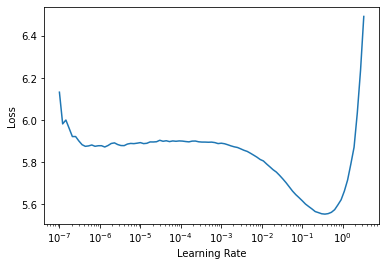

In [92]:
learn_lm.lr_find()

In [93]:
learn_lm.fit_one_cycle??

In [28]:
learn_lm.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.231648,3.827815,0.334648,45.961994,18:21


In [11]:
learn_lm.save('new_1epoch')

Path('/home/advaitmb/notebooks/datasets/models/1epoch.pth')

In [50]:
learn_lm = learn_lm.load('1epoch')

Freezed model fine-tuning

In [51]:
learn_lm.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.411040,3.963558,0.317454,52.644287,19:00
1,4.235998,3.814587,0.334261,45.358002,18:57
2,4.173708,3.773794,0.338691,43.544968,18:51
3,4.131014,3.756031,0.340658,42.778294,18:53
4,4.108287,3.752107,0.341137,42.610752,18:52


Unfreezed model fine-tuning

In [34]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.806759,3.614240,0.358794,37.123127,21:32
1,3.678196,3.433414,0.386771,30.982243,21:31
2,3.544537,3.328203,0.401229,27.888180,21:30
3,3.435940,3.256172,0.411960,25.950008,21:30
4,3.338380,3.236395,0.414796,25.441835,21:30


In [52]:
learn_lm.save('5epochs_frozen')

Path('/home/advaitmb/notebooks/datasets/models/5epochs_frozen.pth')

In [53]:
learn.export('/home/advaitmb/notebooks/projects/PreDiction/5epochslearner_frozen.pkl')

In [35]:
learn_lm.save('5epochs')

Path('/home/advaitmb/notebooks/datasets/models/5epochs.pth')

In [11]:
learn = learn_lm.load('5epochs')

In [12]:
learn.export('/home/advaitmb/notebooks/projects/PreDiction/5epochslearner.pkl')

In [60]:
learn_lm.predict('What do you think', n_words=20, temperature=0.6)

"What do you think the Australian President on Halloween is ? a Halloween Party . What 's"

Beam Search Algorithm replicated from fastai1 

In [58]:
def beam_search(learn, text:str, n_words:int, no_unk:bool=True, top_k:int=10, beam_sz:int=1000, temperature:float=1.,
                    sep:str=' ', decoder=decode_spec_tokens):
    learn.model.reset()
    learn.model.eval()
    idx = learn.dls.test_dl([text]).items[0][None]
    nodes = None
    nodes = idx.clone()
    scores = idx.new_zeros(1).float()
    if no_unk: unk_idx = learn.dls.vocab.index(UNK)
    with torch.no_grad():
        for k in progress_bar(range(n_words), leave=False):
            out = F.log_softmax(learn.model(idx)[0][:,-1], dim=-1)
            if no_unk: out[:, unk_idx] = -float('Inf')
            values, indices = out.topk(top_k, dim=-1)
            scores = (-values + scores[:,None]).view(-1)
            indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
            sort_idx = scores.argsort()[:beam_sz]
            scores = scores[sort_idx]
            nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                                    indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
            nodes = nodes.view(-1, nodes.size(2))[sort_idx]
            learn.hidden = [(h[0][:,indices_idx[sort_idx],:],h[1][:,indices_idx[sort_idx],:]) for h in learn.model[0].hidden]
            idx = nodes[:,-1][:,None]
        if temperature != 1.: scores.div_(temperature)
        node_idx = torch.multinomial(torch.exp(-scores), 1).item()
        num = learn.dls.train_ds.numericalize
        tokens = [num.vocab[i] for i in nodes[node_idx][1:] if num.vocab[i] not in [BOS, PAD]]
        sep = learn.dls.train_ds.tokenizer.sep
        return sep.join(decoder(tokens))

In [56]:
learn_lm = load_learner('/home/advaitmb/notebooks/projects/PreDiction/5epochslearner_frozen.pkl'); learn_lm

In [ ]:
beam_search(learn_lm, text='Hello I am', n_words=20, temperature=0.6)

In [15]:
def preds_acts(learn, ds_type=DatasetType.Valid):
    "Same as `get_predictions` but also returns non-reconstructed activations"
    learn.model.eval()
    ds = learn.data.train_ds
    rxs,rys,rzs,xs,ys,zs = [],[],[],[],[],[] # 'r' == 'reconstructed'
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                rxs.append(ds.x.reconstruct(x))
                rys.append(ds.y.reconstruct(y))
                preds = z.argmax(1)
                rzs.append(ds.y.reconstruct(preds))
                for a,b in zip([xs,ys,zs],[x,y,z]): a.append(b)
    return rxs,rys,rzs,xs,ys,zs

NameError: name 'DatasetType' is not defined

In [ ]:
def select_topk(outp, k=5):
    probs = F.softmax(outp,dim=-1)
    vals,idxs = probs.topk(k, dim=-1)
    return idxs[torch.randint(k, (1,))]

In [ ]:
def select_nucleus(outp, p=0.5):
    probs = F.softmax(outp,dim=-1)
    idxs = torch.argsort(probs, descending=True)
    res,cumsum = [],0.
    for idx in idxs:
        res.append(idx)
        cumsum += probs[idx]
        if cumsum>p: return idxs.new_tensor([choice(res)])

In [ ]:
def decode(self, inp):
    inp = inp[None]
    bs, sl = inp.size()
    hid,enc_out = self.encoder(bs, inp)
    dec_inp = inp.new_zeros(bs).long() + self.bos_idx
    enc_att = self.enc_att(enc_out)

    res = []
    for i in range(self.out_sl):
        hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
        dec_inp = select_nucleus(outp[0], p=0.3)
#         dec_inp = select_topk(outp[0], k=2)
        res.append(dec_inp)
        if (dec_inp==self.pad_idx).all(): break
    return torch.cat(res)

In [ ]:
def predict_with_decode(learn, x, y):
    learn.model.eval()
    ds = learn.data.train_ds
    with torch.no_grad():
        out = decode(learn.model, x)
        rx = ds.x.reconstruct(x)
        ry = ds.y.reconstruct(y)
        rz = ds.y.reconstruct(out)
    return rx,ry,rz

In [ ]:
 def predict(self, text, n_words=1, no_unk=True, temperature=1., min_p=None, no_bar=False,
                decoder=decode_spec_tokens, only_last_word=False):
        "Return `text` and the `n_words` that come after"
        self.model.reset()
        idxs = idxs_all = self.dls.test_dl([text]).items[0].to(self.dls.device)
        if no_unk: unk_idx = self.dls.vocab.index(UNK)
        for _ in (range(n_words) if no_bar else progress_bar(range(n_words), leave=False)):
            with self.no_bar(): preds,_ = self.get_preds(dl=[(idxs[None],)])
            res = preds[0][-1]
            if no_unk: res[unk_idx] = 0.
            if min_p is not None:
                if (res >= min_p).float().sum() == 0:
                    warn(f"There is no item with probability >= {min_p}, try a lower value.")
                else: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1).item()
            idxs = idxs_all = torch.cat([idxs_all, idxs.new([idx])])
            if only_last_word: idxs = idxs[-1][None]

        num = self.dls.train_ds.numericalize
        tokens = [num.vocab[i] for i in idxs_all if num.vocab[i] not in [BOS, PAD]]
        sep = self.dls.train_ds.tokenizer.sep
        return sep.join(decoder(tokens))

In [ ]:
def beam_search(self, text:str, n_words:int, no_unk:bool=True, top_k:int=10, beam_sz:int=1000, temperature:float=1.,
                    sep:str=' ', decoder=decode_spec_tokens):
        "Return the `n_words` that come after `text` using beam search."
        self.model.reset()
        self.model.eval()
        xb, yb = self.data.one_item(text)
        nodes = None
        nodes = xb.clone()
        scores = xb.new_zeros(1).float()
        with torch.no_grad():
            for k in progress_bar(range(n_words), leave=False):
                out = F.log_softmax(self.model(xb)[0][:,-1], dim=-1)
                if no_unk: out[:,self.data.vocab.stoi[UNK]] = -float('Inf')
                values, indices = out.topk(top_k, dim=-1)
                scores = (-values + scores[:,None]).view(-1)
                indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
                sort_idx = scores.argsort()[:beam_sz]
                scores = scores[sort_idx]
                nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                                indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
                nodes = nodes.view(-1, nodes.size(2))[sort_idx]
                self.model[0].select_hidden(indices_idx[sort_idx])
                xb = nodes[:,-1][:,None]
        if temperature != 1.: scores.div_(temperature)
        node_idx = torch.multinomial(torch.exp(-scores), 1).item()
        return text + sep + sep.join(decoder(self.data.vocab.textify([i.item() for i in nodes[node_idx][1:] ], sep=None)))

In [18]:
text = "Hello I am"

In [19]:
n_words = 10
no_unk=True
top_k = 10
beam_sz = 1000
temperature=1.
sep:str=' '
decoder=decode_spec_tokens

In [ ]:
learn.model.reset()
learn.model.eval()
idx = learn.dls.test_dl([text]).items[0][None]
nodes = None
nodes = idx.clone()
scores = idx.new_zeros(1).float()

# if no_unk: unk_idx = learn.dls.vocab.index(UNK)
with torch.no_grad():
    for k in progress_bar(range(n_words), leave=False):
        out = F.log_softmax(learn.model(idx)[0][:,-1], dim=-1)
#         if no_unk: out[unk_idx] = 0.
        values, indices = out.topk(top_k, dim=-1)
        scores = (-values + scores[:,None]).view(-1)
        indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
        sort_idx = scores.argsort()[:beam_sz]
        scores = scores[sort_idx]
        nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                                indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
        nodes = nodes.view(-1, nodes.size(2))[sort_idx]
        learn.hidden = [(h[0][:,indices_idx[sort_idx],:],h[1][:,indices_idx[sort_idx],:]) for h in learn.model[0].hidden]
        idx = nodes[:,-1][:,None]
    if temperature != 1.: scores.div_(0.6)
    node_idx = torch.multinomial(torch.exp(-scores), 1).item()
    num = learn.dls.train_ds.numericalize
    tokens = [num.vocab[i] for i in nodes[node_idx][1:] if num.vocab[i] not in [BOS, PAD]]
    sep = learn.dls.train_ds.tokenizer.sep
    print(sep.join(decoder(tokens)))